In [102]:
%pylab inline
import sys
sys.path
sys.path.insert(0, '/Users/asaadeldin/Downloads/GitHub/scipy')

from scipy.optimize import linear_sum_assignment
from scipy.optimize import minimize_scalar
from sklearn.utils import check_array
from sklearn.utils import column_or_1d

Populating the interactive namespace from numpy and matplotlib


/Users/asaadeldin/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['mat']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [103]:
from scipy.optimize import quadratic_assignment

In [3]:
def convex_approx(A, B, seeds_A=[], seeds_B=[], maximize = False):
        if not maximize:
            A=-A
        A = check_array(A, copy=True, ensure_2d=True)
        B = check_array(B, copy=True, ensure_2d=True)
        seeds_A = column_or_1d(seeds_A)
        seeds_B = column_or_1d(seeds_B)
        
        n = A.shape[0]  # number of vertices in graphs
        n_seeds = seeds_A.shape[0]  # number of seeds
        n_unseed = n - n_seeds

        obj_func_scalar = 1
        #if self.gmp:
            #obj_func_scalar = -1

        A12 = A[:n_seeds, n_seeds:]
        A21 = A[n_seeds:, :n_seeds]
        A22 = A[n_seeds:, n_seeds:]

        B12 = B[:n_seeds, n_seeds:]
        B21 = B[n_seeds:, :n_seeds]
        B22 = B[n_seeds:, n_seeds:]
        
        AtA = np.transpose(np.concatenate((A12,A22),axis=0)) @ np.concatenate((A12,A22),axis=0)
        BBt = np.concatenate((B21,B22),axis=1) @ np.transpose(np.concatenate((B21,B22),axis=1))

        AB21_12 = A21 @ np.transpose(B21) + np.transpose(A12) @ B12
        P = np.ones((n_unseed, n_unseed)) / float(n_unseed)
        
        grad_P = math.inf  # gradient of P
        n_iter = 0
            
        #while grad_P > self.eps and n_iter < self.max_iter:
        while n_iter<100:
            delta_f = (AtA @ P + P @ BBt - AB21_12 - np.transpose(A22) @ P @ B22 - A22 @ P @ B22) #if janky check this
            rows, cols = linear_sum_assignment(-obj_func_scalar * delta_f)

            Q = np.zeros((n_unseed, n_unseed))
            Q[rows, cols] = 1 

            C22 = (A22 @ (P-Q)) - ((P-Q) @ B22)
            D22 = (A22 @ Q) - (Q @ B22)

            if (n_seeds > 0):
                C21 = -(P-Q) @ B21
                C12 = A12 @ (P-Q)

                D21 = A21 - Q @ B21
                D12 = A12 @ Q - B12
            else:
                C21, C12, D21, D12 = 0,0,0,0

            aq = np.sum(np.multiply(C22,C22)) + np.sum(np.multiply(C21,C21)) + np.sum(np.multiply(C12,C12)) #if janky check this
            bq = np.sum(np.multiply(C22, D22)) + np.sum(np.multiply(C21, D21)) + np.sum(np.multiply(C12, D12))
            

            if aq == 0:
                alpha = 0
            else:
                alpha = -bq/aq

            P_i1 = alpha*P + (1-alpha)*Q
            f_new = np.sum(np.multiply(A22 @ P_i1 - P_i1 @ B22,A22 @ P_i1 - P_i1 @ B22))
            grad_P = np.linalg.norm(P - P_i1)
            P = P_i1
            n_iter += 1

        row, col = linear_sum_assignment(-P)
        P_f = np.zeros((n_unseed, n_unseed))
        P_f[rows, cols] = 1 
        return P_f


In [47]:
qapprob = ["chr12c","chr15a","chr15c","chr20b","chr22b","esc16b",
          "rou12","rou15","rou20","tai12a","tai15a","tai17a","tai20a",
          "tai30a","tai35a","tai40a"]
qapprob = ["bur26a", "bur26b", "bur26c", "bur26d", "bur26e", "bur26f",
              "bur26g", "bur26h", "chr12a", "chr12b", "chr12c", "chr15a",
              "chr15b", "chr15c", "chr18a", "chr18b", "chr20a", "chr20b",
              "chr20c", "chr22a", "chr22b", "chr25a",
              "els19",
              "esc16a", "esc16b", "esc16c", "esc16d", "esc16e", "esc16g",
              "esc16h", "esc16i", "esc16j", "esc32g", "esc128",
              "had12", "had14", "had16", "had18", "had20", "kra30a",
              "kra30b", "kra32",
              "lipa20a", "lipa20b", "lipa30a", "lipa30b", "lipa40a", "lipa40b",
              "lipa50a", "lipa50b", "lipa60a", "lipa60b", "lipa70a", "lipa70b",
              "lipa80a", "lipa90a", "lipa90b",
              "nug12", "nug14", "nug16a", "nug16b", "nug17", "nug18", "nug20",
              "nug21", "nug22", "nug24", "nug25", "nug27", "nug28", "nug30",
              "rou12", "rou15", "rou20",
              "scr12", "scr15", "scr20",
              "sko42", "sko49", "sko56", "sko64", "sko72", "sko81", "sko90",
              "sko100a", "sko100b", "sko100c", "sko100d", "sko100e", "sko100f",
              "ste36b", "ste36c",
              "tai12a", "tai12b", "tai15a", "tai15b", "tai17a", "tai20a",
              "tai20b", "tai25a", "tai25b", "tai30a", "tai30b", "tai35a",
              "tai40a", "tai40b", "tai50a", "tai50b", "tai60a", "tai60b",
              "tai64c", "tai80a", "tai100a", "tai100b", "tai150b", "tai256c",
              "tho30", "tho40", "tho150", "wil50", "wil100"]

slnfile = np.load("qap_sols.npz",allow_pickle=True)
datafile = np.load("qap_probs.npz",allow_pickle=True)
n_qap = len(qapprob)
convex_scores = np.zeros(n_qap)
bari_scores = np.zeros(n_qap)
den = 1
for i in range(n_qap):
    c_min = [0]*den
    b_min = [0]*den
    u_min = [0]*den
    for k in range(den):
        A = datafile[qapprob[i]][0]
        B = datafile[qapprob[i]][1]
        n = A.shape[0]
        res = quadratic_assignment(A,B, init = convex_approx(A,B))
        c_min[k] = res['score']

        res = quadratic_assignment(A,B)
        b_min[k] = res['score']
        
        
    convex_scores[i] = min(c_min)
    bari_scores[i] = min(b_min)

#print(convex_scores)
#print(bari_scores)

In [48]:
import pandas as pd
opt = [slnfile[i] for i in qapprob]
mat = np.zeros((n_qap,3))
mat[:,0] = opt
mat[:,1] = bari_scores
mat[:,2] = convex_scores
#mat[:,1] = (bari_scores-opt)/opt
#mat[:,2] = (convex_scores-opt)/opt
#(bari_scores-opt)/opt
df = pd.DataFrame(mat,columns=["OPT","Bary Init", "Convex Init"])
df.insert(0,"QAP",qapprob,True)
print(df)

        QAP        OPT  Bary Init  Convex Init
0    bur26a  5426670.0  5434876.0    5436235.0
1    bur26b  3817852.0  3826996.0    3840024.0
2    bur26c  5426795.0  5435115.0    5430322.0
3    bur26d  3821225.0  3825612.0    3844135.0
4    bur26e  5386879.0  5389477.0    5392579.0
..      ...        ...        ...          ...
116   tho30   149936.0   151682.0     153682.0
117   tho40   240516.0   248068.0     243080.0
118  tho150  8133398.0  8227848.0    8223472.0
119   wil50    48816.0    49066.0      49632.0
120  wil100   273038.0   273688.0     275878.0

[121 rows x 4 columns]


In [167]:
mat = np.zeros((n_qap,2))
mat[:,0] = (bari_scores-opt)/opt
mat[:,1] = (convex_scores-opt)/opt

Text(0, 0.5, 'Percent Diff from the Optimum')

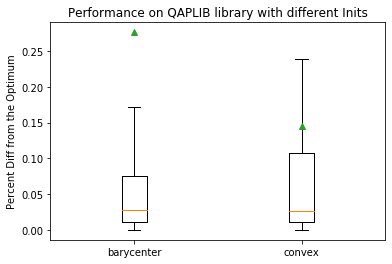

In [50]:
mat = np.zeros((n_qap,2))
mat[:,0] = (bari_scores-opt)/opt
mat[:,1] = (convex_scores-opt)/opt
fig, ax = plt.subplots()
ax.set_title('Performance on QAPLIB library with different Inits')
ax.boxplot(mat, showfliers=False, labels = ['barycenter', 'convex'], showmeans=True)
ylabel('Percent Diff from the Optimum')

Text(0, 0.5, 'Percent Diff from the Optimum')

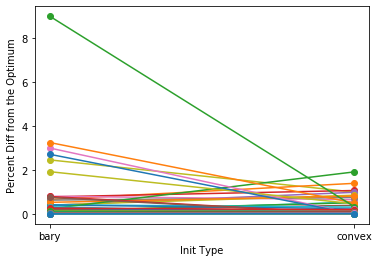

In [51]:
plt.plot(['bary','convex'],mat.T, marker='o')
xlabel('Init Type')
ylabel('Percent Diff from the Optimum')

#legend(qapprob, bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)

In [46]:
qapprob[32]


'esc32e'

In [164]:
A = datafile['esc128'][1]
np.nonzero(A)

(array([  0,   0,   0, ..., 127, 127, 127]),
 array([  3,   5,   6, ..., 121, 122, 124]))

In [159]:
A

array([[0, 0, 0, ..., 5, 5, 6],
       [0, 0, 1, ..., 4, 6, 5],
       [0, 1, 0, ..., 6, 4, 5],
       ...,
       [5, 4, 6, ..., 0, 1, 0],
       [5, 6, 4, ..., 1, 0, 0],
       [6, 5, 5, ..., 0, 0, 0]])

In [166]:
import time
start = time.time()
row,col = linear_sum_assignment(A, maximize=False)
end = time.time()
print('the run time is: ',str(end-start))
A[row,col].sum()

the run time is:  0.0045697689056396484


0

In [101]:
linear_sum_assignment(A, maximize =True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 array([ 1,  0,  4,  5,  2,  3,  6,  9, 10,  7,  8, 11]))

In [121]:
def doubly_stochastic(P, eps=1e-3):
    max_iter = 1000
    c = 1 / P.sum(axis=0)
    r = 1 / (P @ c)
    P_eps = P

    for it in range(max_iter):
        if ((np.abs(P_eps.sum(axis=1) - 1) < eps).all() and
                (np.abs(P_eps.sum(axis=0) - 1) < eps).all()):
            # All column/row sums ~= 1 within threshold
            reason = f"Threshold satisfied within {it+1} iterations"
            break

        c = 1 / (r @ P)
        r = 1 / (P @ c)
        P_eps = r[:, None] * P * c
    else:
        reason = "Max iter reached"

    return P_eps

In [138]:
def perturb(init_weight = 0.5, n_init = 30):
    qapprob = ["bur26a", "bur26b", "bur26c", "bur26d", "bur26e", "bur26f",
                  "bur26g", "bur26h", "chr12a", "chr12b", "chr12c", "chr15a",
                  "chr15b", "chr15c", "chr18a", "chr18b", "chr20a", "chr20b",
                  "chr20c", "chr22a", "chr22b", "chr25a",
                  "els19",
                  "esc16a", "esc16b", "esc16c", "esc16d", "esc16e", "esc16g",
                  "esc16h", "esc16i", "esc16j", "esc32g", "esc128",
                  "had12", "had14", "had16", "had18", "had20", "kra30a",
                  "kra30b", "kra32",
                  "lipa20a", "lipa20b", "lipa30a", "lipa30b", "lipa40a", "lipa40b",
                  "lipa50a", "lipa50b", "lipa60a", "lipa60b", "lipa70a", "lipa70b",
                  "lipa80a", "lipa90a", "lipa90b",
                  "nug12", "nug14", "nug16a", "nug16b", "nug17", "nug18", "nug20",
                  "nug21", "nug22", "nug24", "nug25", "nug27", "nug28", "nug30",
                  "rou12", "rou15", "rou20",
                  "scr12", "scr15", "scr20",
                  "sko42", "sko49", "sko56", "sko64", "sko72", "sko81", "sko90",
                  "sko100a", "sko100b", "sko100c", "sko100d", "sko100e", "sko100f",
                  "ste36b", "ste36c",
                  "tai12a", "tai12b", "tai15a", "tai15b", "tai17a", "tai20a",
                  "tai20b", "tai25a", "tai25b", "tai30a", "tai30b", "tai35a",
                  "tai40a", "tai40b", "tai50a", "tai50b", "tai60a", "tai60b",
                  "tai64c", "tai80a", "tai100a", "tai100b", "tai150b", "tai256c",
                  "tho30", "tho40", "tho150", "wil50", "wil100"]
    qapprob = ["chr12c","chr15a","chr15c","chr20b","chr22b","esc16b",
              "rou12","rou15","rou20","tai12a","tai15a","tai17a","tai20a",
              "tai30a","tai35a","tai40a"]
    slnfile = np.load("qap_sols.npz",allow_pickle=True)
    datafile = np.load("qap_probs.npz",allow_pickle=True)
    n_qap = len(qapprob)
    convex_scores = np.zeros(n_qap)
    bari_scores = np.zeros(n_qap)
    n_init = 30
    init_weight = 0.5
    for i in range(n_qap):
        c_min = [0]*n_init
        b_min = [0]*n_init
        for k in range(n_init):
            A = datafile[qapprob[i]][0]
            B = datafile[qapprob[i]][1]
            n = A.shape[0]
            K = doubly_stochastic(np.random.rand(n,n))
            cj = init_weight*convex_approx(A,B) + (1-init_weight)*K
            res = quadratic_assignment(A,B, init = cj)
            c_min[k] = res['score']

            res = quadratic_assignment(A,B, init = 'rand')
            b_min[k] = res['score']


        convex_scores[i] = min(c_min)
        bari_scores[i] = min(b_min)
    return bari_scores, convex_scores
#print(convex_scores)
#print(bari_scores)

Text(0, 0.5, 'Percent Diff from the Optimum')

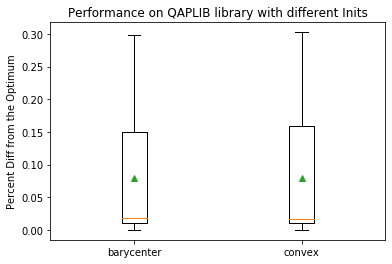

In [148]:
import pandas as pd
opt = [slnfile[i] for i in qapprob]
mat = np.zeros((n_qap,2))
mat[:,0] = (bari_scores-opt)/opt
mat[:,1] = (convex_scores-opt)/opt
fig, ax = plt.subplots()
ax.set_title('Performance on QAPLIB library with different Inits')
ax.boxplot(mat, showfliers=False, labels = ['barycenter', 'convex'], showmeans=True)
ylabel('Percent Diff from the Optimum')

Text(0.5, 1.0, 'Init-weight = 0.5')

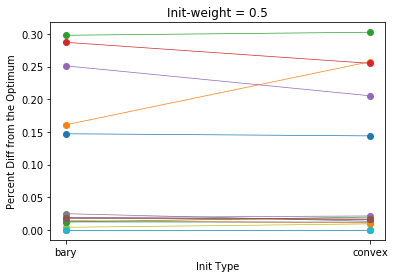

In [149]:
plt.plot(['bary','convex'],mat.T, marker='o', linewidth=.7)
xlabel('Init Type')
ylabel('Percent Diff from the Optimum')
title('Init-weight = 0.5')
#legend

In [150]:
b_25, c_25 = perturb(init_weight = 0.25)


Text(0, 0.5, 'Percent Diff from the Optimum')

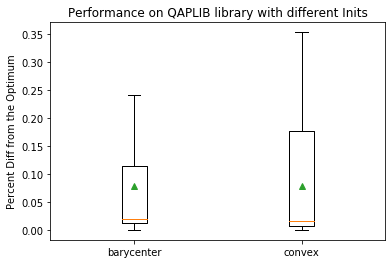

In [153]:
import pandas as pd
opt = [slnfile[i] for i in qapprob]
mat25 = np.zeros((n_qap,2))
mat25[:,0] = (b_25-opt)/opt
mat25[:,1] = (c_25-opt)/opt
fig, ax = plt.subplots()
ax.set_title('Performance on QAPLIB library with different Inits')
ax.boxplot(mat, showfliers=False, labels = ['barycenter', 'convex'], showmeans=True)
ylabel('Percent Diff from the Optimum')

Text(0.5, 1.0, 'Init-weight = 0.25')

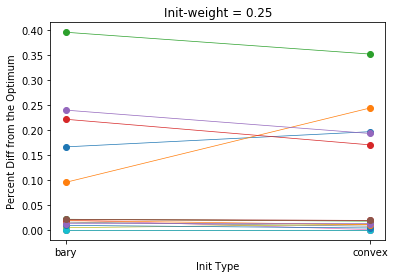

In [154]:
plt.plot(['bary','convex'],mat25.T, marker='o', linewidth=.7)
xlabel('Init Type')
ylabel('Percent Diff from the Optimum')
title('Init-weight = 0.25')


In [155]:
b_75, c_75 = perturb(init_weight = 0.75)

Text(0, 0.5, 'Percent Diff from the Optimum')

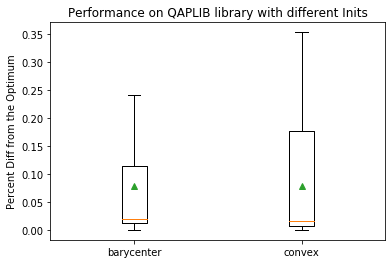

In [156]:

opt = [slnfile[i] for i in qapprob]
mat75 = np.zeros((n_qap,2))
mat75[:,0] = (b_75-opt)/opt
mat75[:,1] = (c_75-opt)/opt
fig, ax = plt.subplots()
ax.set_title('Performance on QAPLIB library with different Inits')
ax.boxplot(mat, showfliers=False, labels = ['barycenter', 'convex'], showmeans=True)
ylabel('Percent Diff from the Optimum')

Text(0.5, 1.0, 'Init-weight = 0.75')

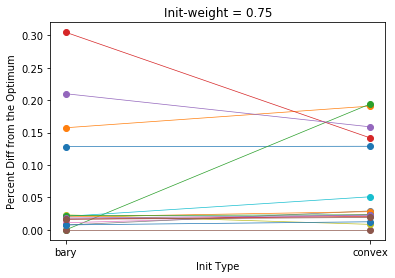

In [157]:
plt.plot(['bary','convex'],mat75.T, marker='o', linewidth=.7)
xlabel('Init Type')
ylabel('Percent Diff from the Optimum')
title('Init-weight = 0.75')